# Spatial Dependence Index

> Is dataset worth modeling?

## Table of Contents:

1. What is the spatial dependcy index?
2. Why do we use spatial dependency index?
3. Example: The comparison of different Spatial Dependence Index over the same extent but different elements.
4. API links.

## Level: Basic

## Changelog

| Date | Change description | Author |
|------|--------------------|--------|
| 2023-04-08 | The first version of the tutorial | @SimonMolinsky |

## Introduction

In this tutorial, we will learn how to estimate **spatial dependency index**. Algorithm is based on the work:

> [1] CAMBARDELLA, C.A.; MOORMAN, T.B.; PARKIN, T.B.; KARLEN, D.L.; NOVAK, J.M.; TURCO, R.F.; KONOPKA, A.E. Field-scale variability of soil properties in central Iowa soils. Soil Science Society of America Journal, v. 58, n. 5, p. 1501-1511, 1994.


## 1. What is the spatial dependency index?

The spatial dependency index (SDI) measures the strength of a spatial process we are modeling. SDI is normalized to the interval between 0 and 1. Therefore, we can transform it into percentages and assign an order of spatial dependency from weak to strong.

The SDI is a ratio of the nugget to the total variance (sill) of a model:

$$SDI = \frac{nugget}{sill} * 100$$

Whenever we perform fitting of a theoretical variogram with the `pyinterpolate` package, then SDI is calculated, and we will take advantage of it in the examples. SDI is represented by two values:

- **numeric**, a ratio of nugget and sill in percent,
- **categorical**, a description of a spatial dependency strength.

There are four levels of spatial dependency.

| Lower Limit (included) | Upper Limit (excluded) | Strength |
|------------------------|------------------------|----------|
| 0                      | 25                     | strong   |
| 25                     | 75                     | moderate |
| 75                     | 95                     | weak     |
| 95                     | _inf_                  | no spatial dependence |


**The lower the ratio, the strongest spatial dependence**. If the ratio is greater than 75 percent, we should be cautious with spatial modeling because spatial similarities may not explain the process.

## 2. Why do we use spatial dependency index?

In a world where Tobler’s Law can be applied to every spatial phenomenon, we might use kriging all the time without consideration. We know that spatial dependence exists, and close neighbors are always similar.

This world is not our world! Not every process follows Tobler’s Law. We can find examples that are sampled over the same area and the same scale but their spatial dependence indexes are different. In [1] (SDI in `pyinterpolate` is based on this publication), there are multiple chemical compounds sampled from the same field. Every compound has its spatial distribution and variogram. There are soil parameters that are not spatially dependent at all (for example, _Mg_ or _Ca_ that are randomly distributed).

The spatial dependence index level marks the next decision on what to do with the data.

- Strong: just krige it!
- Moderate: there might be some other thing that explains process variation.
- Weak: the other non-spatial process has more influence on data than spatial similarities.
- No spatial dependence: the process is random, or spatial dependencies cannot explain variance.

**Note**: Be careful because the last two points are red flags, BUT sometimes processes with a low variogram variability at one scale may be explained with spatial relations at a changed scale. A practical example is a comparison of rental apartment prices per night: if you look at the scale of hundreds of kilometers, the spatial dependence may be very weak or none. On the other hand, the spatial similarity between prices of apartments close to each other (up to 10 kilometers, 6 miles) tends to show a _classic variogram curve_. The reason is simple: most managers and algorithms use information about the pricing of the closest neighbors, and neighborhood prices are affected by the same external objects or events.

We should look into the spatial dependence index to ensure our path leads us toward meaningful results.

## Example: Spatial Dependence over the same study extent but for different elements

We will compare spatial dependece index of four elements: cadmium, copper, lead, and zinc. We use *meuse* dataset. The dataset comes from:

<br>

> Pebesma, Edzer. (2009). The meuse data set: a tutorial for the gstat R package -> [link to the publication](https://cran.r-project.org/web/packages/gstat/vignettes/gstat.pdf)

In [1]:
import numpy as np
import pandas as pd
import pyinterpolate as ptp

In [2]:
MEUSE_FILE = 'samples/point_data/csv/meuse/meuse.csv'

# Variogram parameters
STEP_SIZE = 100
MAX_RANGE = 1600
ALLOWED_MODELS = ['linear', 'spherical']


# Elements
ELEMENTS = ['cadmium', 'copper', 'zinc', 'lead']
COLS = ['x', 'y']
COLS.extend(ELEMENTS)

In [3]:
df = pd.read_csv(MEUSE_FILE, usecols=COLS)
df.head()

,x,y,cadmium,copper,lead,zinc
0,181072,333611,11.7,85,299,1022
1,181025,333558,8.6,81,277,1141
2,181165,333537,6.5,68,199,640
3,181298,333484,2.6,81,116,257
4,181307,333330,2.8,48,117,269


Data is skewed for every element in the table. Before we start variogram modeling, we must transform it into a distribution close to normality. We will use a logarithmic transform, pass data into an experimental variogram, and then create theoretical models with the `autofit()` method. We will use *grid search* to find the best possible nugget value.

Optimal model for element cadmium has 43.85% of nugget to sill ratio. Spatial Dependence is moderate.


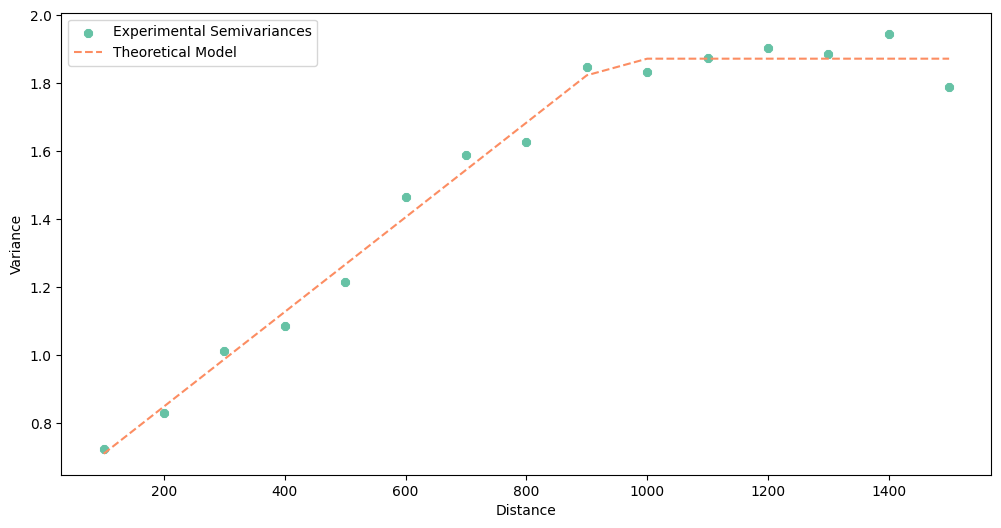


---

Optimal model for element copper has 25.27% of nugget to sill ratio. Spatial Dependence is moderate.


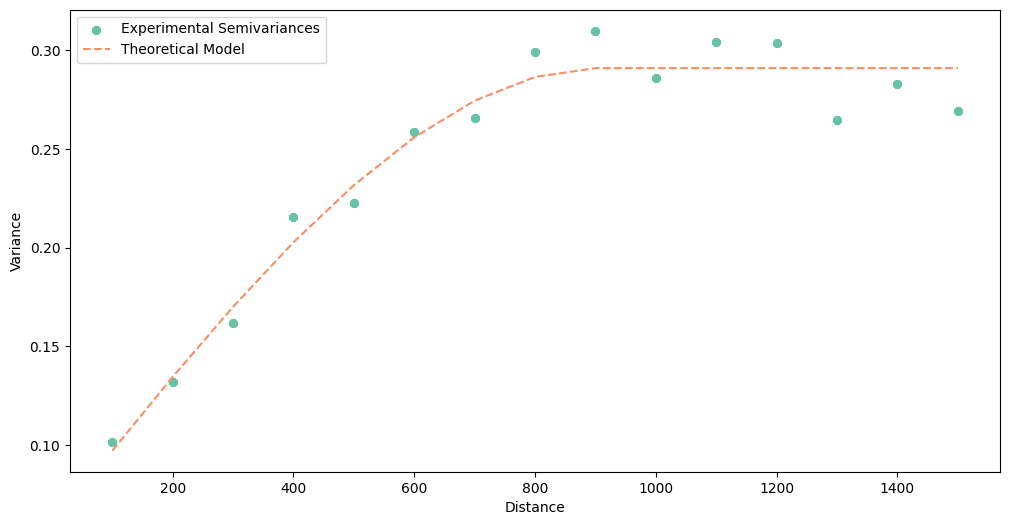


---

Optimal model for element zinc has 22.46% of nugget to sill ratio. Spatial Dependence is strong.


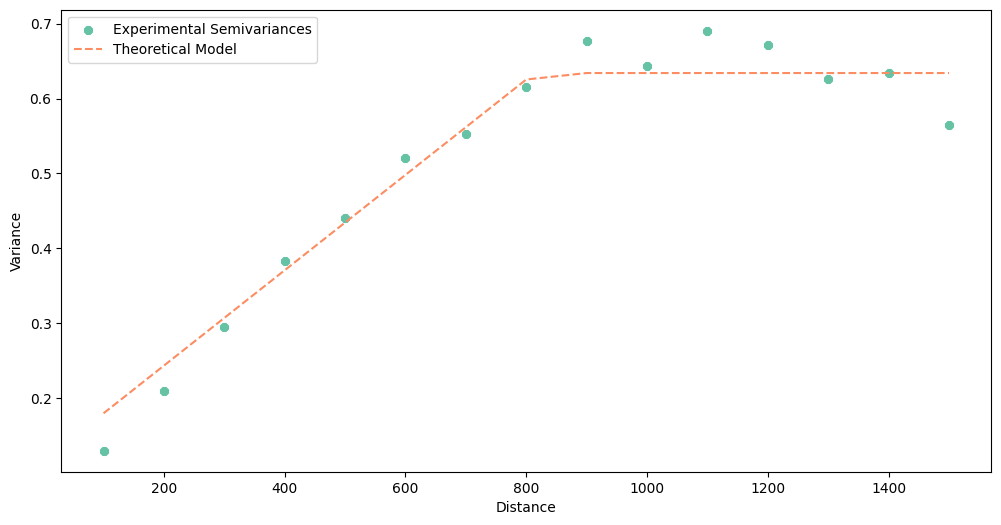


---

Optimal model for element lead has 25.27% of nugget to sill ratio. Spatial Dependence is moderate.


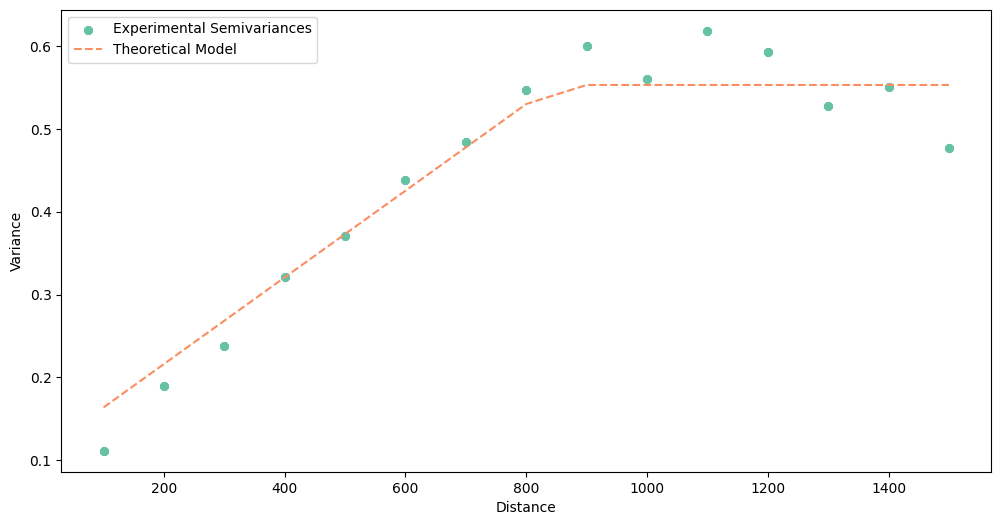


---



In [4]:
def find_optimal_model(experimental_variogram: ptp.ExperimentalVariogram, allowed_models):
    """
    Function finds optimal theoretical model.
    """
    nugget_high = experimental_variogram.experimental_semivariances.min()
    nuggets = np.linspace(0, nugget_high, 20)
    
    # Calculate the first model
    theo_init = ptp.TheoreticalVariogram()
    theo_init.autofit(experimental_variogram=experimental_variogram,
                      model_types=allowed_models,
                      nugget=nuggets[0])
    
    optimal_model = theo_init
    optimal_rmse = theo_init.rmse
    
    # Check other models
    for ngt in nuggets[1:]:
        theo_ = ptp.TheoreticalVariogram()
        theo_.autofit(experimental_variogram=experimental_variogram,
                      model_types=allowed_models,
                      nugget=ngt)
        if theo_.rmse < optimal_rmse:
            optimal_model = theo_
            optimal_rmse = theo_.rmse
            
    return optimal_model


for element in ELEMENTS:
    # Prepare data
    ds = df[['x', 'y', element]].copy()
    ds[element] = np.log(ds[element])
    arr = ds.values
    
    # Get experimental variogram
    exp_var = ptp.build_experimental_variogram(arr, step_size=STEP_SIZE, max_range=MAX_RANGE)
    
    # Find optimal theoretical model
    optimal_model = find_optimal_model(exp_var, ALLOWED_MODELS)
    print('Optimal model for element {} has {:.2f}% of nugget to sill ratio. Spatial Dependence is {}.'.format(
        element, optimal_model.spatial_dependency_ratio, optimal_model.spatial_dependency_strength
    ))
    optimal_model.plot()
    
    print('\n---\n')
    

**SUMMARY**

Every element from the set has a different strength of spatial dependence. We see that processes that influence the spatial distribution of those elements differ.

## API

Spatial dependence index may be calculated directly with the `calculate_spatial_dependence_index()` function that takes two parameters: `nugget` and `sill`. It returns `Tuple` with spatial dependence ratio and spatial dependence strength.

Another way is to calculate `TheoreticalVariogram` **with `nugget` greater than 0**. The SDI is undefined for `nugget = 0`.

---